<a href="https://colab.research.google.com/github/ua-datalab/Bioinformatics/blob/main/MLFlow/Bioinformatics_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leveraging MLflow for Experiment Tracking in Bioinformatics


## Installing Packages

In [1]:
# !pip install mlflow pandas scikit-learn numpy

## 1. Import Libraries

In [2]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load and Explore the Dataset

In [3]:
# Load the dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Display the first few rows
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
# prompt: analyze this dataframe like a professional data scientist. include any figure or measurement such as correlation required to understand the data. also include your interepretion of the results

import matplotlib.pyplot as plt
import seaborn as sns

# Display basic statistics
print(df.describe())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Data Types
print("\nData Types:\n", df.dtypes)

       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

## 3. Data Preprocessing

In [5]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Set Up MLflow Experiment

In [6]:
mlflow.set_experiment("Breast_Cancer_Classification")

<Experiment: artifact_location='file:///workspaces/Bioinformatics/MLFlow/mlruns/107985550435718349', creation_time=1729888139082, experiment_id='107985550435718349', last_update_time=1729888139082, lifecycle_stage='active', name='Breast_Cancer_Classification', tags={}>

## 5. Define and Run Experiments

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def run_experiment(n_estimators, max_depth):
    with mlflow.start_run():
        # Log parameters
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("roc_auc", roc_auc)

        # Log model
        mlflow.sklearn.log_model(model, "random_forest_model")

        # Log confusion matrix as an artifact
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Print metrics
        print(f"Parameters: n_estimators={n_estimators}, max_depth={max_depth}")
        print(f"Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

# Run experiments with different hyperparameters
n_estimators_list = [50, 100, 150]
max_depth_list = [5, 10]

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        run_experiment(n_estimators, max_depth)

2024/10/29 21:29:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=50, max_depth=5
Accuracy: 0.9561, ROC AUC: 0.9937


2024/10/29 21:29:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=50, max_depth=10
Accuracy: 0.9561, ROC AUC: 0.9919


2024/10/29 21:29:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=100, max_depth=5
Accuracy: 0.9561, ROC AUC: 0.9934


2024/10/29 21:29:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=100, max_depth=10
Accuracy: 0.9561, ROC AUC: 0.9939


2024/10/29 21:29:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=150, max_depth=5
Accuracy: 0.9474, ROC AUC: 0.9931


2024/10/29 21:29:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Parameters: n_estimators=150, max_depth=10
Accuracy: 0.9561, ROC AUC: 0.9931


## 6. Viewing Experiment Results

In [8]:
# Retrieve experiment ID
experiment_id = mlflow.get_experiment_by_name("Breast_Cancer_Classification").experiment_id

# Fetch all runs from the experiment
runs = mlflow.search_runs(experiment_ids=experiment_id)

# Display the runs
runs_df = runs[["run_id", "params.n_estimators", "params.max_depth", "metrics.accuracy", "metrics.roc_auc"]]
runs_df.sort_values(by="metrics.roc_auc", ascending=False, inplace=True)
runs_df.reset_index(drop=True, inplace=True)
runs_df

/tmp/ipykernel_23612/892939034.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_df.sort_values(by="metrics.roc_auc", ascending=False, inplace=True)


,run_id,params.n_estimators,params.max_depth,metrics.accuracy,metrics.roc_auc
0,5e265090972a4bbd9e5f6d1b58faf70a,100,10,0.956140,0.993882
1,d6153827b390471bbab1d66a09b198c7,100,10,0.956140,0.993882
2,601c69e1155e43f99dcb123288fbd289,50,5,0.956140,0.993717
3,80c66c4a661e4dea9a02d75559d918c9,50,5,0.956140,0.993717
4,79fabe4b9ce9458f80ca60ac367ad634,100,5,0.956140,0.993386
5,d440529513fb4908b76d290df3fc462b,100,5,0.956140,0.993386
6,ff40f721e80844a395525307c268f472,150,10,0.956140,0.993056
7,62527f2e83b74f508cbe389c52be8b7b,150,5,0.947368,0.993056
8,93332b6735514a779d38c9e76393da5b,150,10,0.956140,0.993056
9,7ca9acc3f0374e75b135be4768dcfcc2,150,5,0.947368,0.993056


## 7. Analyze Results

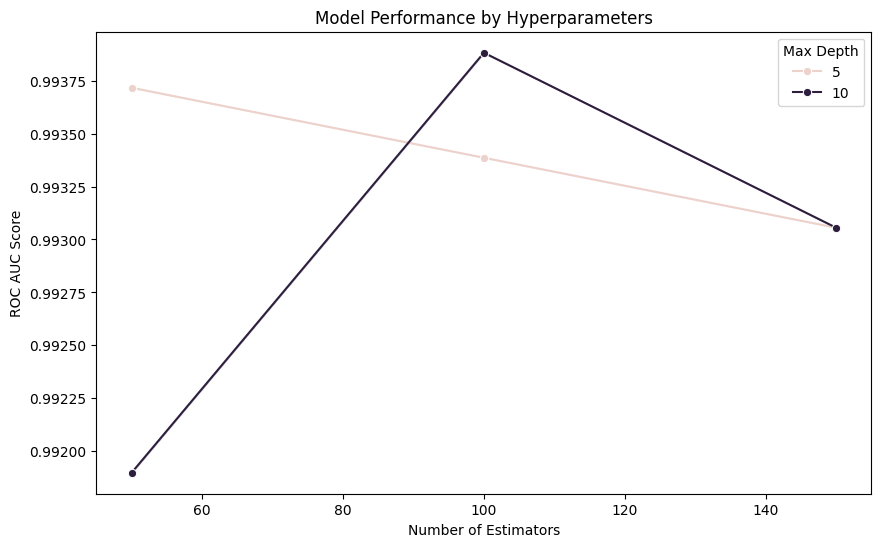

In [9]:
# Fill None values with a default integer value (e.g., 0) and convert parameter columns to numeric
runs_df.loc[:, 'params.n_estimators'] = runs_df['params.n_estimators'].fillna(0).astype(int)
runs_df.loc[:, 'params.max_depth'] = runs_df['params.max_depth'].fillna(0).astype(int)

# Plot performance
plt.figure(figsize=(10,6))
sns.lineplot(data=runs_df, x='params.n_estimators', y='metrics.roc_auc', hue='params.max_depth', marker='o')
plt.title('Model Performance by Hyperparameters')
plt.xlabel('Number of Estimators')
plt.ylabel('ROC AUC Score')
plt.legend(title='Max Depth')
plt.show()

## 8. Load and Evaluate the Best Model

In [10]:
# Get the best run ID
best_run_id = runs_df.iloc[0]['run_id']
print('best_run_id', best_run_id)

# Load the model
best_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/random_forest_model")

# Make predictions
y_pred_best = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_best))

best_run_id 5e265090972a4bbd9e5f6d1b58faf70a
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



### Renaming the best model

In [11]:
# Rename the existing MLflow session
new_run_name = "Best_Model_Run"

with mlflow.start_run(run_id=best_run_id):
    mlflow.set_tag("mlflow.runName", new_run_name)

print(f"Run with ID {best_run_id} has been renamed to '{new_run_name}'.")

Run with ID 5e265090972a4bbd9e5f6d1b58faf70a has been renamed to 'Best_Model_Run'.


### Running more experiment on the best model using 'with'

RandomForestClassifier(max_depth=10, random_state=42)


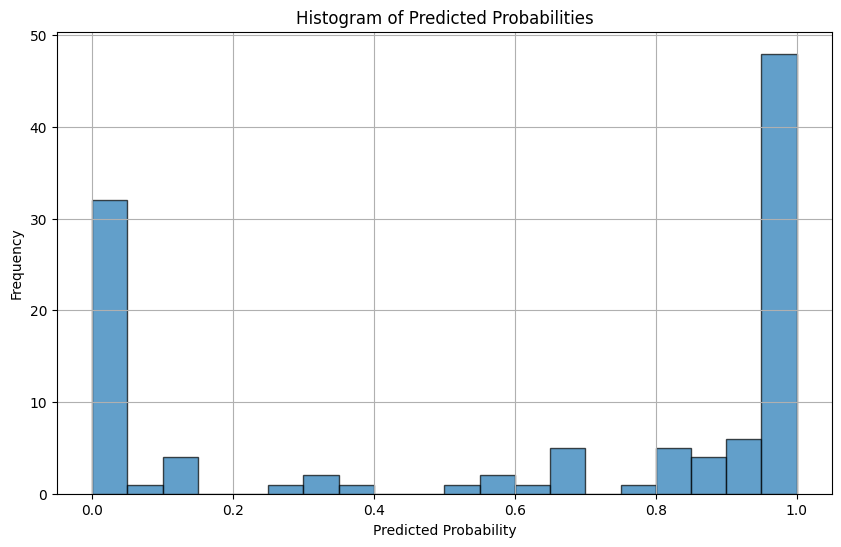

In [12]:
# Start an existing run
with mlflow.start_run(run_id=best_run_id):
    # Load the model artifact
    model_uri = f"runs:/{best_run_id}/random_forest_model"
    loaded_model = mlflow.sklearn.load_model(model_uri)

    # Make predictions using the best model
    y_proba_best = loaded_model.predict_proba(X_test)[:, 1]

    # Plot histogram of the predicted probabilities
    plt.figure(figsize=(10, 6))
    plt.hist(y_proba_best, bins=20, edgecolor='k', alpha=0.7)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Save the plot
    histogram_path = "predicted_probabilities_histogram.png"
    plt.savefig(histogram_path)
    mlflow.log_artifact(histogram_path)

# Verify the model is loaded
print(loaded_model)

In [13]:
import git

# Start an existing run
with mlflow.start_run(run_id=best_run_id) as run:
    repo = git.Repo(search_parent_directories=True)
    mlflow.set_tag('mlflow.source.git.commit', repo.head.object.hexsha)
    mlflow.set_tag('mlflow.source.name'      , run.data.tags['mlflow.source.name'])

### Running more experiment on the best model without using 'with'

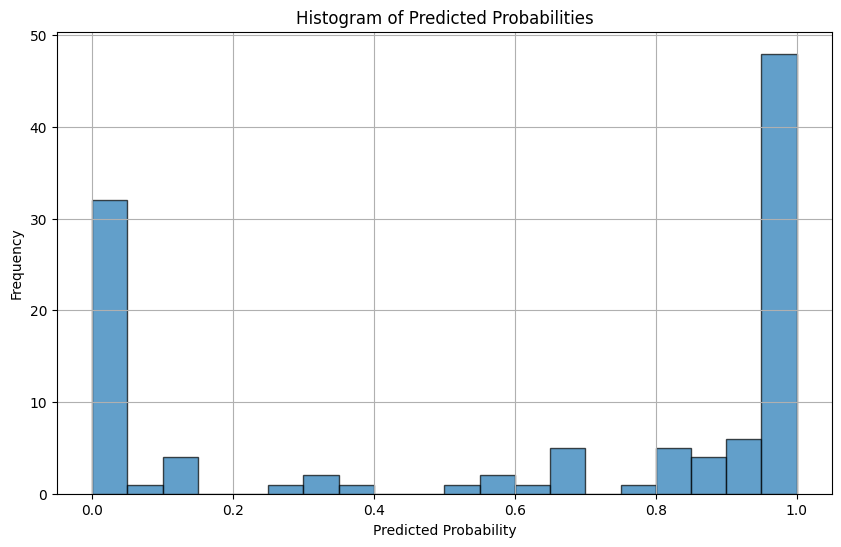

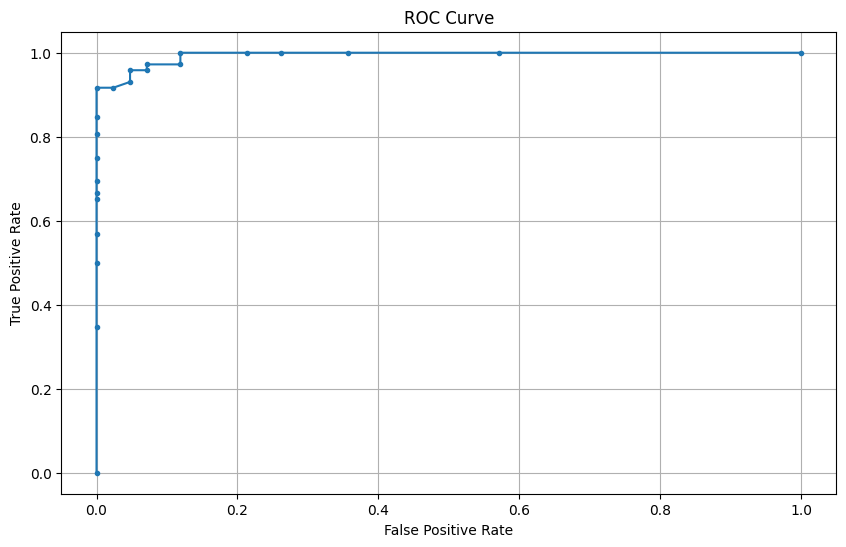

In [14]:
# Start an existing run
run = mlflow.start_run(run_id=best_run_id)

# Load the model artifact
model_uri = f"runs:/{best_run_id}/random_forest_model"
loaded_model = mlflow.sklearn.load_model(model_uri)

# Make predictions using the best model
y_proba_best = loaded_model.predict_proba(X_test)[:, 1]

# Plot histogram of the predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(y_proba_best, bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)

# Save the plot
histogram_path = "predicted_probabilities_histogram.png"
plt.savefig(histogram_path)
mlflow.log_artifact(histogram_path)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

# Save the ROC curve plot
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
mlflow.log_artifact(roc_curve_path)



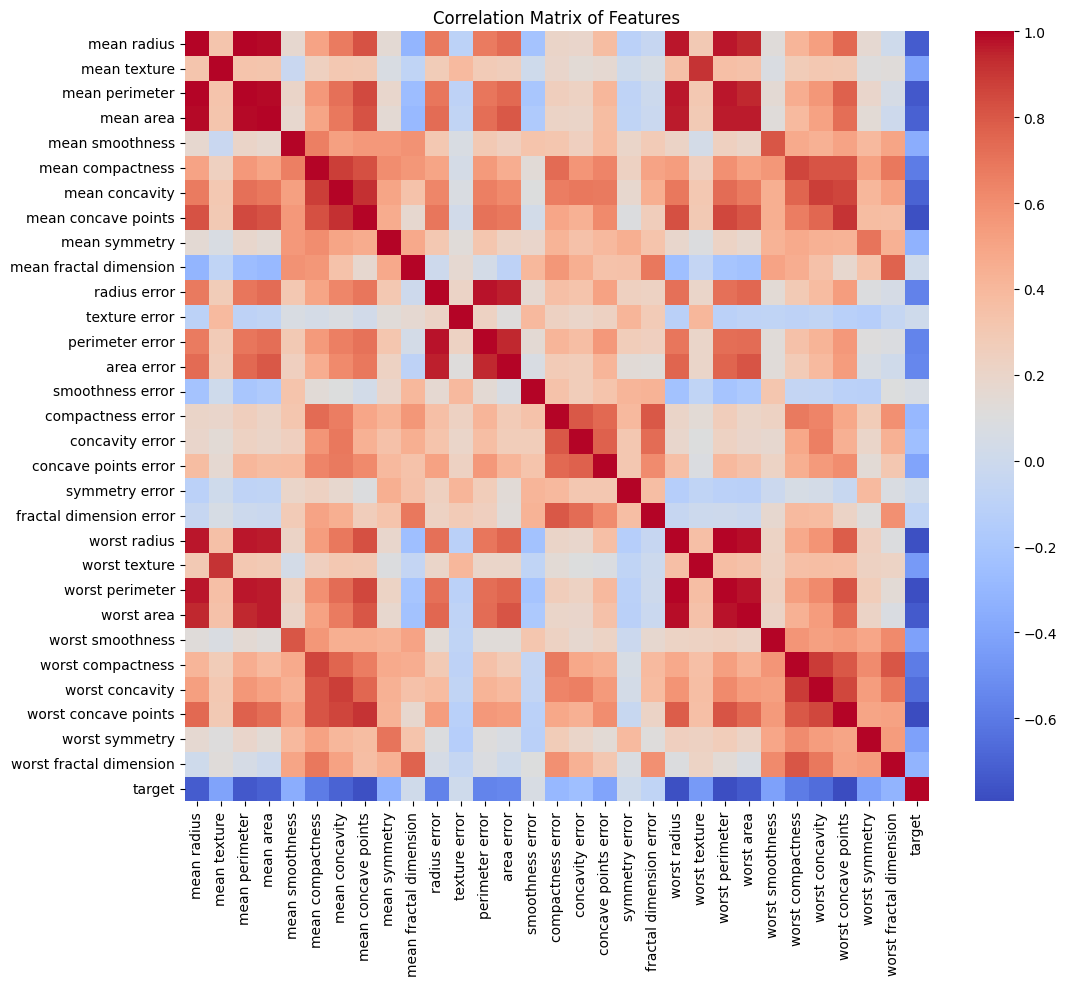

In [15]:
# Correlation analysis
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
# plt.show()

# Save the ROC curve plot
corr_matrix = "correlation_matrix.png"
plt.savefig(corr_matrix)
mlflow.log_artifact(corr_matrix)

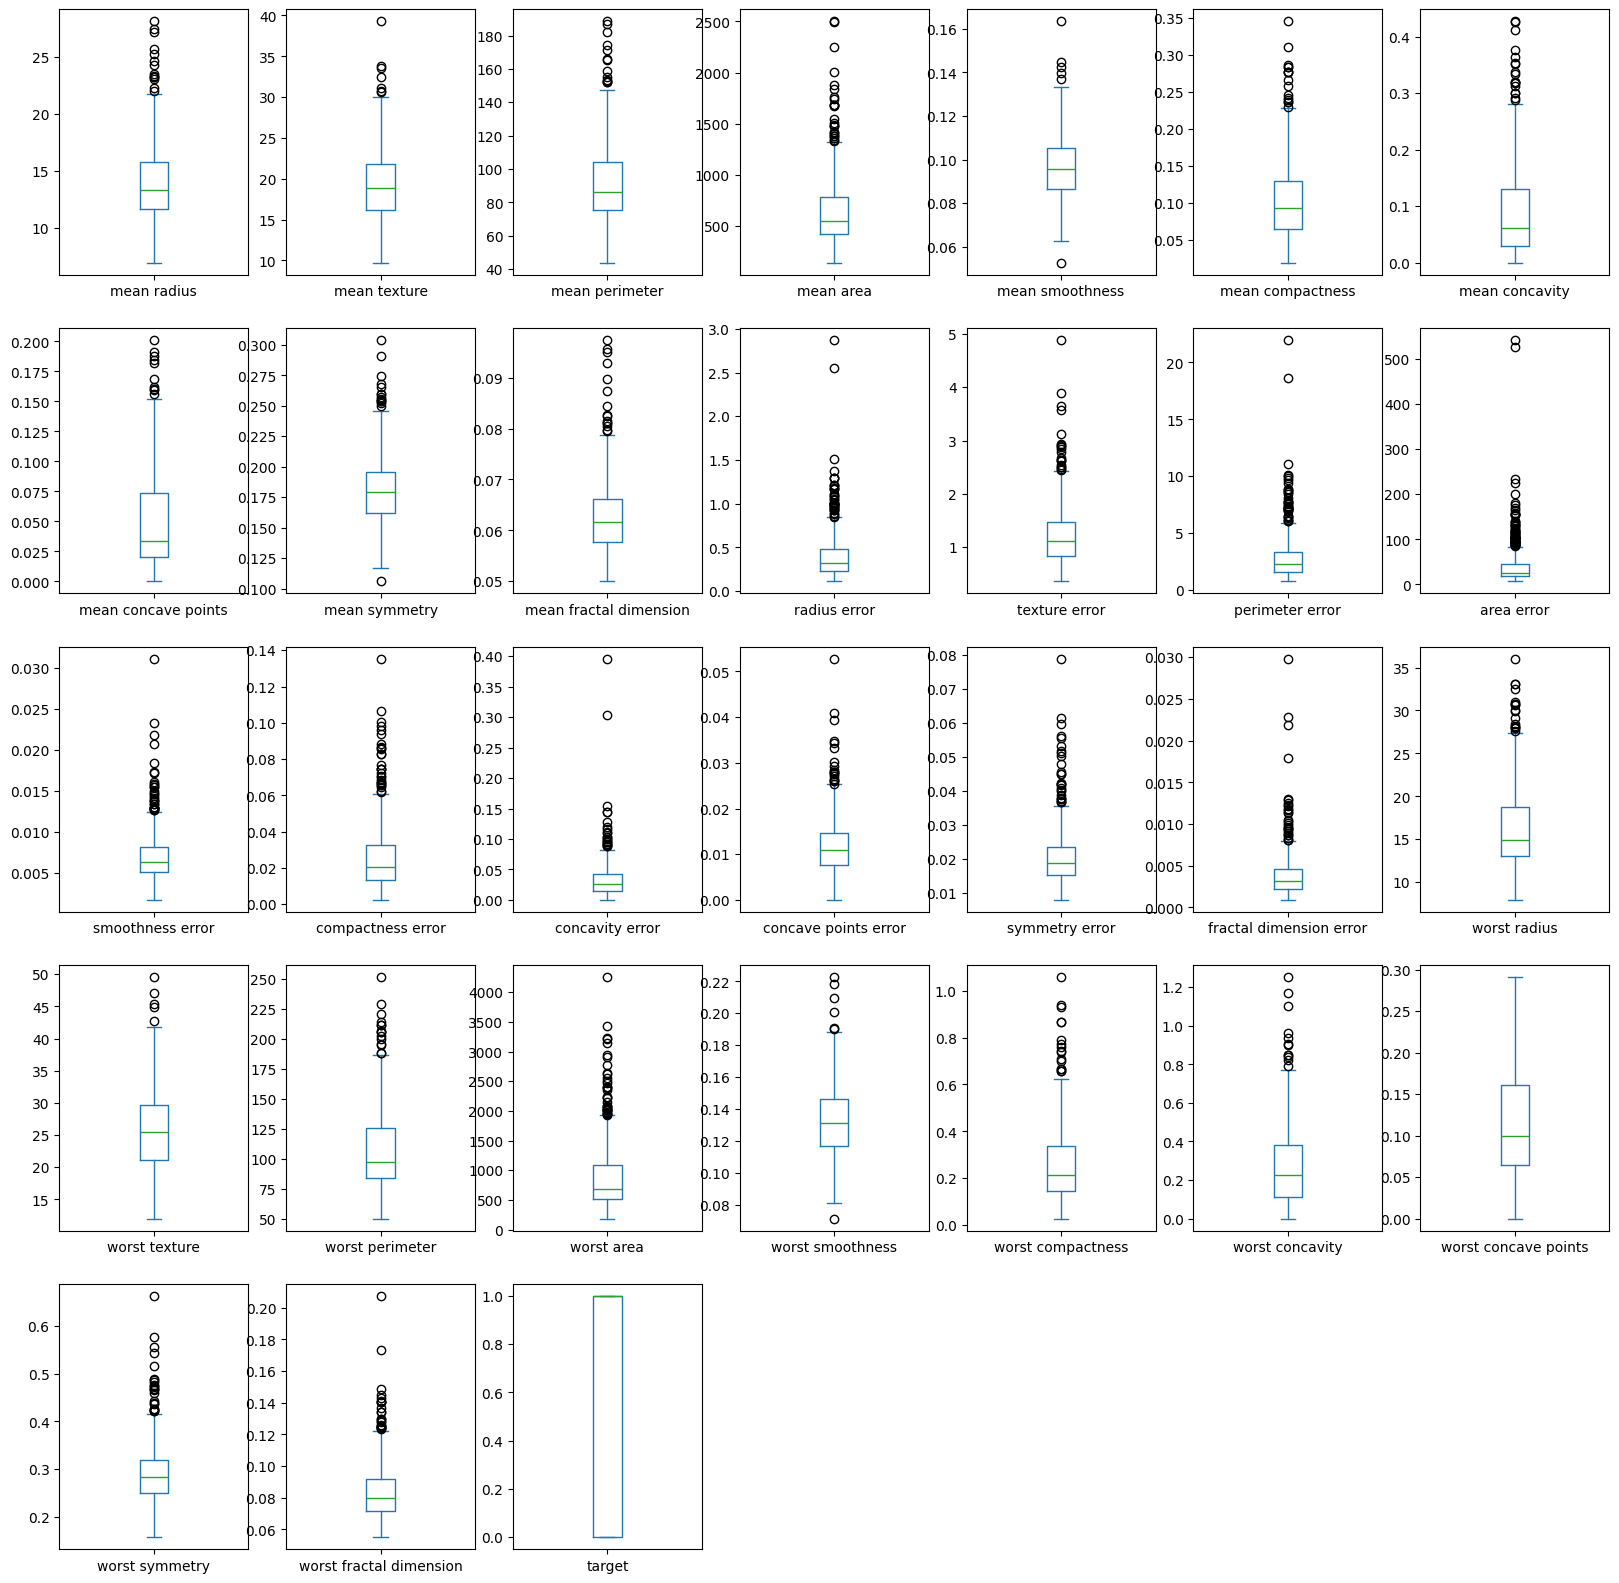

In [16]:
# Boxplots for each feature
df.plot(kind='box', subplots=True, layout=(5,7), sharex=False, sharey=False, figsize=(20, 20))

# Save the plot
box_plot = "box_plot.png"
plt.savefig(box_plot)
mlflow.log_artifact(box_plot)

In [17]:
# End the run
mlflow.end_run()

# Verify the model is loaded
print(loaded_model)

RandomForestClassifier(max_depth=10, random_state=42)


In [18]:
!mlflow ui

[2024-10-29 21:29:41 +0000] [23925] [INFO] Starting gunicorn 23.0.0
[2024-10-29 21:29:41 +0000] [23925] [INFO] Listening at: http://127.0.0.1:5000 (23925)
[2024-10-29 21:29:41 +0000] [23925] [INFO] Using worker: sync
[2024-10-29 21:29:41 +0000] [23926] [INFO] Booting worker with pid: 23926
[2024-10-29 21:29:41 +0000] [23927] [INFO] Booting worker with pid: 23927
[2024-10-29 21:29:41 +0000] [23928] [INFO] Booting worker with pid: 23928
[2024-10-29 21:29:41 +0000] [23929] [INFO] Booting worker with pid: 23929
^C
[2024-10-29 21:30:46 +0000] [23925] [INFO] Handling signal: int
[2024-10-29 21:30:46 +0000] [23929] [INFO] Worker exiting (pid: 23929)
[2024-10-29 21:30:46 +0000] [23926] [INFO] Worker exiting (pid: 23926)
[2024-10-29 21:30:46 +0000] [23928] [INFO] Worker exiting (pid: 23928)
[2024-10-29 21:30:46 +0000] [23927] [INFO] Worker exiting (pid: 23927)
